# Learning English Past Tense: In Response to Rumelhart and McClelland
### Michael Ginn

In 1985, Rumelhart and McClelland helped to pioneer the emerging field of neural network models for language processing in their paper, *On Learning the Past Tenses of English Verbs*. Certainly, this was a critical landmark in the connectionist approach to linguistics, but Rumelhart and McClelland were limited by the technology and theoretical knowledge of their time. 

Thus, the model they created was somewhat limited in its effectiveness. While it made correct conclusions and errors that matched human language acquisition, it also produced highly unusual errors such as predicting "membled" as the past tense form of "mail".

Nowadays, neural networks are incredibly easy to build and train even with very complex models. Furthermore, our understanding of connectist linguistics has greatly improved. There is now much evidence that morphology has a role in language acquisition, and that considering morphological information can be very beneficial on neural networks (Rueckl & Raveh 1999). 

Thus, the goal of this notebook is to build a model using modern techniques to solve the same problem as Rumelhart and McClelland, predicting the past tense forms of English verbs. However, we will make a few changes, as described below.

### Deep Learning
The Rumelhart and McClelland (from here on, R&M) paper uses a single-layer perceptron that maps directly from input to output features, primarily due to technological limits of the time. Modern machine learning theory tends heavily toward deep models, where there are multiple "hidden" layers in between the input and output layers. These layers are critical in representing patterns where data is not linearly separable and allow neural networks to achieve very accurate results. Thus, our model will use hidden layers. The number and size of these layers will be decided through cross-validation.

### Morphological Features
The R&M model maps word inputs to Wickelfeatures, which encodes each letter as the previous and following letter. Through this, the model is trained with each stem as the input and their past tense form as the output.

![The R&M network architecture](./model.png)

It is clear, then, that this model makes no consideration of morphology. If we assume that learners utilize morphological information, then this model clearly misses out on valuable information. It is akin to attempting to classify an image by looking only at the raw pixels, without using the convolutional features that all modern computer vision models use. 

Therefore, our model will train on morphology. Specifically, our input will be phonological representations of the stem of a verb, and the output will be one of the possible past tense morphemes, such as -ed or -u-. This allows our model to predict the past tense morpheme for a new word, and thereby to predict the full form, assuming that other processes handle the phonological transformation.

The question arises, however, of whether this learner learns similar to a human learner. After all, humans are not explicitly provided with morphemes and stems. 

However, I would argue that the separation of words into morphemes is a separate process, which could also be modeled (but is out of scope for this project). A learner is unlikely to be able to divide a word such as "ran" or "walked" into constituent morphemes, unless A) they have encountered the word before, B) they have seen similar words and can infer this word's makeup, and/or C) the word is in context and they predict that because it is an inflected form, it has multiple morphemes. Thus, we could construct an algorithm that does this process.

Furthermore, note that this model retains the intuition that a key factor in learner predictions on novel data is phonological similarity. Learners will often predict the *-ed* morpheme for most words, unless they are very similar to another word, such as the imaginary "zwing", which some learners predict to inflect to "zwang". 

### Other Models
Last, neural networks are not the only structure used in modern data science, and we know that human brains do not necessarily work like neural networks. Thus, it is possible that other models could be very effective in learning past tense inflection, and thus might provide insight into how human learners learn. Specifically, we will look at a nearest neighbors classification model, which uses similarity between data points to predict their class.

## Overview
This project will take the following steps.
1. First, we will prepare data by producing a representation of stems and past tense morphemes.
2. Next, we will cross-validate to determine optimal hyperparameters for the model.
3. We will train the model on a subset of the data.
4. We will evaluate the model on the unseen data, comparing our results to the R&M paper. We will also discuss the learning process of the model and the sorts of errors it makes.
5. Last, we will repeat steps 2-4 with a k-Nearest Neighbors model.

## Data Preparation
First, we will import some data on English verbs.

In [2]:
from nltk.corpus import brown
import nltk

# Find all the instances from the corpus of verbs that are past tense
past_verbs = {} # Will hold words and their frequency counts
for w in list(filter(lambda w: w[1] == 'VBD', brown.tagged_words())):
    word = w[0].lower()
    past_verbs[word] = 1 if not word in past_verbs else past_verbs[word] + 1
        
past_verbs = list(past_verbs.items())

past_verbs[:30]

[('said', 1747),
 ('produced', 28),
 ('took', 426),
 ('recommended', 17),
 ('commented', 16),
 ('urged', 21),
 ('found', 268),
 ('added', 81),
 ('praised', 8),
 ('filed', 12),
 ('charged', 17),
 ('listed', 11),
 ('became', 246),
 ('announced', 53),
 ('brought', 133),
 ('attended', 24),
 ('wanted', 204),
 ('voted', 22),
 ('resigned', 7),
 ('approved', 12),
 ('opened', 94),
 ('told', 286),
 ('passed', 91),
 ('pointed', 48),
 ('rejected', 12),
 ('asked', 300),
 ('tossed', 22),
 ('put', 130),
 ('saw', 338),
 ('defeated', 5)]

In [3]:
# Next, we'll lemmatize these words into their bare forms.

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/milesper/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()

lemmatizer.lemmatize("took", 'v')

'take'

Notice that this lemmatizer fails in a few cases where words may be homophones, such as "saw". We will have to correct these manually. We can detect this by looking at the instances where the lemmatized form is identical to the input form.

In [5]:
lemmatized_forms = [(v[0], v[1], lemmatizer.lemmatize(v[0], 'v')) for v in past_verbs]
lemmatized_forms[:30]

[('said', 1747, 'say'),
 ('produced', 28, 'produce'),
 ('took', 426, 'take'),
 ('recommended', 17, 'recommend'),
 ('commented', 16, 'comment'),
 ('urged', 21, 'urge'),
 ('found', 268, 'find'),
 ('added', 81, 'add'),
 ('praised', 8, 'praise'),
 ('filed', 12, 'file'),
 ('charged', 17, 'charge'),
 ('listed', 11, 'list'),
 ('became', 246, 'become'),
 ('announced', 53, 'announce'),
 ('brought', 133, 'bring'),
 ('attended', 24, 'attend'),
 ('wanted', 204, 'want'),
 ('voted', 22, 'vote'),
 ('resigned', 7, 'resign'),
 ('approved', 12, 'approve'),
 ('opened', 94, 'open'),
 ('told', 286, 'tell'),
 ('passed', 91, 'pass'),
 ('pointed', 48, 'point'),
 ('rejected', 12, 'reject'),
 ('asked', 300, 'ask'),
 ('tossed', 22, 'toss'),
 ('put', 130, 'put'),
 ('saw', 338, 'saw'),
 ('defeated', 5, 'defeat')]

Let's find all the instances where the lemmatized form is identical. This will let us correct the mis-lemmatizations.

In [6]:
for i, w in enumerate(lemmatized_forms):
    if not w[0] == w[2]: continue
    print(i, w)

27 ('put', 130, 'put')
28 ('saw', 338, 'saw')
64 ('felt', 302, 'felt')
153 ('read', 36, 'read')
209 ('beat', 12, 'beat')
216 ('cut', 25, 'cut')
224 ('set', 71, 'set')
235 ('bet', 1, 'bet')
260 ('lay', 81, 'lay')
267 ('hit', 38, 'hit')
275 ('gruonded', 1, 'gruonded')
314 ('cost', 10, 'cost')
316 ('fell', 87, 'fell')
353 ("bulletin'd", 1, "bulletin'd")
475 ('bid', 1, 'bid')
567 ('double-bogeyed', 1, 'double-bogeyed')
709 ('let', 37, 'let')
717 ('burst', 11, 'burst')
733 ('upset', 1, 'upset')
770 ('thrust', 9, 'thrust')
802 ('spread', 18, 'spread')
838 ('cast', 4, 'cast')
863 ('bore', 14, 'bore')
873 ('shed', 3, 'shed')
907 ('underlay', 1, 'underlay')
931 ('spit', 3, 'spit')
961 ('hop-skipped', 1, 'hop-skipped')
1073 ('bed-hopped', 1, 'bed-hopped')
1093 ('co-operated', 1, 'co-operated')
1120 ('sowered', 1, 'sowered')
1122 ('thout', 1, 'thout')
1123 ('recond', 1, 'recond')
1124 ('sed', 1, 'sed')
1125 ('though', 1, 'though')
1127 ('brok', 1, 'brok')
1128 ('run', 1, 'run')
1129 ('holored', 1

Now let's fix these words if necessary. We will also remove some weird instances such as "pfffted".

In [7]:
corrected_lemmatized_forms = lemmatized_forms
corrected_lemmatized_forms[28] = ('saw', 337, 'see')
corrected_lemmatized_forms[64] = ('felt', 302, 'feel')
corrected_lemmatized_forms[316] = ('fell', 87, 'fall')
corrected_lemmatized_forms[1370] = ('incanted', 1, 'incant')
corrected_lemmatized_forms[1611] = ('reemerged', 1, 'reemerge')
corrected_lemmatized_forms[1795] = ('smelt', 3, 'smelted')
corrected_lemmatized_forms[1844] = ('lucked', 1, 'luck')
corrected_lemmatized_forms[1900] = ('doled', 1, 'dole')
corrected_lemmatized_forms[2064] = ('reentered', 1, 'reenter')
corrected_lemmatized_forms[2069] = ('holstered', 1, 'holster')
corrected_lemmatized_forms[2210] = ('fisted', 1, 'fist')
corrected_lemmatized_forms[2271] = ('refolded', 1, 'refold')

indices_to_delete = [275, 353, 567, 907, 961, 1073, 1093, 1120, 1122, 1123, 
                     1124, 1125, 1127, 1128, 1129, 1130, 1465, 1481, 1496, 1499,
                     1503, 1504, 1505, 1506, 1517, 1553, 1581, 1630, 1740, 1822, 
                     1928, 1964, 2020, 2036, 2038, 2093, 2095, 2153, 2184, 2201, 
                     2202, 2208, 2305
                    ]

for index in reversed(indices_to_delete):
    del corrected_lemmatized_forms[index]
    
for i, w in enumerate(corrected_lemmatized_forms):
    if not w[0] == w[2]: continue
    print(i, w)

27 ('put', 130, 'put')
153 ('read', 36, 'read')
209 ('beat', 12, 'beat')
216 ('cut', 25, 'cut')
224 ('set', 71, 'set')
235 ('bet', 1, 'bet')
260 ('lay', 81, 'lay')
267 ('hit', 38, 'hit')
313 ('cost', 10, 'cost')
473 ('bid', 1, 'bid')
706 ('let', 37, 'let')
714 ('burst', 11, 'burst')
730 ('upset', 1, 'upset')
767 ('thrust', 9, 'thrust')
799 ('spread', 18, 'spread')
835 ('cast', 4, 'cast')
860 ('bore', 14, 'bore')
870 ('shed', 3, 'shed')
927 ('spit', 3, 'spit')
1235 ('beset', 1, 'beset')
1322 ('rid', 1, 'rid')
1510 ('quit', 2, 'quit')
1666 ('split', 5, 'split')
1727 ('wet', 2, 'wet')
1794 ('shut', 7, 'shut')
1991 ('broadcast', 1, 'broadcast')
2221 ('hurt', 1, 'hurt')
2235 ('fit', 1, 'fit')


### Creating Phonetic Representations
Now, let's convert both forms into phonetic representations. There is one problem: some orthographic representations have multiple pronounciations, which are critical in past tense formation. For instance, we must distinguish between "read" (present) and "read" (past). We will account for this manually.

In [8]:
!pip install cmudict
import cmudict

cmu = cmudict.dict()

def pronounce(word):
    if word in cmu:
        return cmudict.dict().get(word)
    else:
        return [None]

pronounce("want")

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.7/bin/python3 -m pip install --upgrade pip' command.


[['W', 'AA1', 'N', 'T'], ['W', 'AO1', 'N', 'T']]

This next step is very slow. Therefore, in order to retrieve the stored value, we use the `%store` command. If you don't want to do the calculation, skip the next cell and run the following.

In [85]:
from tqdm.notebook import tqdm

phonetic_forms = []

for (verb_past, freq, stem) in tqdm(lemmatized_forms):
    past_form_prounciation = pronounce(verb_past)
    stem_form_prounciation = pronounce(stem)
    phonetic_forms.append((stem_form_prounciation, past_form_prounciation, freq))

phonetic_forms[153] = ([['R', 'IY1', 'D']], [['R', 'EH1', 'D']], 36)
%store phonetic_forms


Stored 'phonetic_forms' (list)


In [9]:
%store -r phonetic_forms

In [10]:
phonetic_forms[:20]

[([['S', 'EY1']], [['S', 'EH1', 'D']], 1747),
 ([['P', 'R', 'AH0', 'D', 'UW1', 'S'], ['P', 'R', 'OW1', 'D', 'UW0', 'S']],
  [['P', 'R', 'AH0', 'D', 'UW1', 'S', 'T']],
  28),
 ([['T', 'EY1', 'K']], [['T', 'UH1', 'K']], 426),
 ([['R', 'EH2', 'K', 'AH0', 'M', 'EH1', 'N', 'D']],
  [['R', 'EH2', 'K', 'AH0', 'M', 'EH1', 'N', 'D', 'IH0', 'D']],
  17),
 ([['K', 'AA1', 'M', 'EH0', 'N', 'T']],
  [['K', 'AA1', 'M', 'EH0', 'N', 'T', 'AH0', 'D']],
  16),
 ([['ER1', 'JH']], [['ER1', 'JH', 'D']], 21),
 ([['F', 'AY1', 'N', 'D']], [['F', 'AW1', 'N', 'D']], 268),
 ([['AE1', 'D']], [['AE1', 'D', 'AH0', 'D'], ['AE1', 'D', 'IH0', 'D']], 81),
 ([['P', 'R', 'EY1', 'Z']], [['P', 'R', 'EY1', 'Z', 'D']], 8),
 ([['F', 'AY1', 'L']], [['F', 'AY1', 'L', 'D']], 12),
 ([['CH', 'AA1', 'R', 'JH']], [['CH', 'AA1', 'R', 'JH', 'D']], 17),
 ([['L', 'IH1', 'S', 'T']],
  [['L', 'IH1', 'S', 'T', 'AH0', 'D'], ['L', 'IH1', 'S', 'T', 'IH0', 'D']],
  11),
 ([['B', 'IH0', 'K', 'AH1', 'M']],
  [['B', 'IH0', 'K', 'EY1', 'M'], ['B', 

In [11]:
import re
master_corpus = []

class CorpusItem:
    def __init__(self, stem, past_form, stem_phonetic, past_form_phonetic, frequency):
        self.stem = stem
        self.past_form = past_form
        self.stem_phonetic = stem_phonetic
        self.past_form_phonetic = past_form_phonetic
        self.frequency = frequency
        
    def __repr__(self):
        return "{ stem: '" + self.stem + "', past: '" + self.past_form + "' }"

for ((verb_past, freq, stem), (stem_form_pronounciation, past_form_pronounciation, _)) in zip(lemmatized_forms, phonetic_forms):
    if stem_form_pronounciation == [None] or past_form_pronounciation == [None]:
        continue
    
    # Strip numbers
    stem_form_pronounciation = [[re.sub(r'\d+', '', alt) for alt in p] for p in stem_form_pronounciation]
    past_form_pronounciation = [[re.sub(r'\d+', '', alt) for alt in p] for p in past_form_pronounciation]
    
    master_corpus.append(CorpusItem(stem, verb_past, stem_form_pronounciation, past_form_pronounciation, freq))
    
master_corpus[:100]

[{ stem: 'say', past: 'said' },
 { stem: 'produce', past: 'produced' },
 { stem: 'take', past: 'took' },
 { stem: 'recommend', past: 'recommended' },
 { stem: 'comment', past: 'commented' },
 { stem: 'urge', past: 'urged' },
 { stem: 'find', past: 'found' },
 { stem: 'add', past: 'added' },
 { stem: 'praise', past: 'praised' },
 { stem: 'file', past: 'filed' },
 { stem: 'charge', past: 'charged' },
 { stem: 'list', past: 'listed' },
 { stem: 'become', past: 'became' },
 { stem: 'announce', past: 'announced' },
 { stem: 'bring', past: 'brought' },
 { stem: 'attend', past: 'attended' },
 { stem: 'want', past: 'wanted' },
 { stem: 'vote', past: 'voted' },
 { stem: 'resign', past: 'resigned' },
 { stem: 'approve', past: 'approved' },
 { stem: 'open', past: 'opened' },
 { stem: 'tell', past: 'told' },
 { stem: 'pass', past: 'passed' },
 { stem: 'point', past: 'pointed' },
 { stem: 'reject', past: 'rejected' },
 { stem: 'ask', past: 'asked' },
 { stem: 'toss', past: 'tossed' },
 { stem: 'put

In [12]:
def find_corpus_item(stem, past=None, corpus=master_corpus):
    """Finds a specified item in the corpus"""
    for item in corpus:
        if item.stem == stem:
            if not (past and not item.past_form == past):
                return item
    return "Item does not exist!!"

find_corpus_item("see").past_form_phonetic

[['S', 'AO']]

### Determining Past Tense Morphemes
The next step is to determine which past tense morpheme is used in each word. We will consider only the underlying form of the morphemes, so both "passed", "pointed", and "attended" all use the `/-ed/` morpheme. We will do this by diffing the stem and past tense form and determining which morpheme the diff is most likely to indicate.

Earlier, we stored all possible pronounciations for the stem and past tense form. Now, we will try diffing every possible combination, and using whichever two forms produce the shortest combination. This allows us to get two forms that are as similar as possible, so that the true morpheme is produced. For instance, "estimate" can be prounounced differently depending on whether it is a noun or verb. However, the verb form should sound more similar to "estimated". 

In [13]:
import difflib

def diff(corpus_item: CorpusItem):
    """Produces a list of the changes between the stem and past tense form"""
    
    # When we run this function on an item, we replace the list of prounounciations with the best ones. Thus, we need to check if this already happened on this item.
    if isinstance(corpus_item.stem_phonetic[0], list):
        best_stem = corpus_item.stem_phonetic[0]
        best_past = corpus_item.past_form_phonetic[0]
        shortest_diff = list(filter(lambda d: d[0] != ' ', difflib.ndiff(best_stem, best_past)))
        for stem_phonetic in corpus_item.stem_phonetic:
            for past_form_phonetic in corpus_item.past_form_phonetic:
                diff = list(filter(lambda d: d[0] != ' ', difflib.ndiff(stem_phonetic, past_form_phonetic)))
                if len(diff) < len(shortest_diff):
                    best_stem = stem_phonetic
                    best_past = past_form_phonetic
                    shortest_diff = diff
                
        corpus_item.stem_phonetic = best_stem
        corpus_item.past_form_phonetic = best_past
    else:
        shortest_diff = list(filter(lambda d: d[0] != ' ', difflib.ndiff(corpus_item.stem_phonetic, corpus_item.past_form_phonetic)))
    
    # In some cases, the orthographic form will help us determine the morpheme, so let's diff that as well
    ortho_diff = list(difflib.ndiff(corpus_item.stem, corpus_item.past_form))
    ortho_diff = list(filter(lambda d: d[0] != ' ', ortho_diff))
    return (shortest_diff, ortho_diff)

diff(find_corpus_item("work", "wrought"))

(['- W', '- ER', '- K', '+ R', '+ AO', '+ T'],
 ['+ r', '- r', '- k', '+ u', '+ g', '+ h', '+ t'])

Rumelhart and McClelland list nine irregular classes in addition to the common `/ed/` morpheme. We will describe these classes as follows.

- Class I is the vacuous morpheme.
- Class II is a change from /d/ to /t/
- Class III and IV represent a vowel change and adding /t/ to the end. I chose to combine these because it seems likely that the distinction between the two is a phonological process, as we might imagine "bring" -> "brɔng" -> "brɔngt" -> "brɔt"
- Class V, VIa, VIb, VII, and VIII all represent internal vowel changes. We will differentiate only based on which vowel is added, assuming it is an infix. This is a useful distinction because it makes our predictions much more powerful.

There is no need to distinguish between allophones/allomorphs of these morphemes, since we are presupposing that morphology and phonology are separate processes.

In [14]:
from enum import Enum
class MORPHEME(str, Enum):
    ED        = "+ed",   # pass -> pass+ed
    NULL      = "Ø",     # hit -> hit
    D_T       = "d->t",   # send -> sent
    VOW_AND_T = "vow change, add /t/",  # feel -> felt, say -> said
    I         = "+ɪ+",    # bite -> bit
    AU        = "+aʊ+",   # find -> found
    O         = "+oʊ+",   # ride -> rode, break -> broke
    AE        = "+æ+",    # sing -> sang, drink -> drank
    EI        = "+eɪ+",   # give -> gave, eat -> ate
    UH        = "+ʌ+",    # sting -> stung, hang -> hung
    U         = "+ʊ+",    # take -> took
    OO        = "+u+",    # fly -> flew, blow -> blew
    AH        = "+ɑ+",    # shoot -> shot
    EH        = "+ɛ+",    # speed -> sped
    SUPP      = "suppletion" # go -> went

    def __str__(self) -> str:
        return str.__str__(self)

    
def determine_morpheme(corpus_item: CorpusItem):
    """Returns the past tense morpheme for a given word"""
    (item_diff, ortho_diff) = diff(corpus_item)
    
    if len(item_diff) == 0:
        return MORPHEME.NULL
    
    # Catches some weird cases where we have different pronounciations of words
    if ortho_diff == ['+ d']:
        return MORPHEME.ED
    
    if len(item_diff) == 1 and (item_diff[0] == "+ T" or item_diff[0] == "+ D"):
        return MORPHEME.ED
    if item_diff == ['- D', '+ T']:
        return MORPHEME.D_T
    if (len(item_diff) == 3 or len(item_diff) == 4) and (item_diff[-1] == "+ T" or item_diff[-1] == "+ D"):
        return MORPHEME.VOW_AND_T
    if len(item_diff) == 2:
        if "+ " in item_diff[0] and (item_diff[1] == "+ T" or item_diff[1] == "+ D"):
            return MORPHEME.ED
        if "+ IH" in item_diff[1]:
            return MORPHEME.I
        if "+ AW" in item_diff[1]:
            return MORPHEME.AU
        if "+ OW" in item_diff[1]:
            return MORPHEME.O
        if "+ AE" in item_diff[1]:
            return MORPHEME.AE
        if "+ EY" in item_diff[1]:
            return MORPHEME.EI
        if "+ AH" in item_diff[1]:
            return MORPHEME.UH
        if "+ UH" in item_diff[1]:
            return MORPHEME.U
        if "+ UW" in item_diff[1]:
            return MORPHEME.OO
        if "+ AA" in item_diff[1] or "+ AO" in item_diff[1]:
            return MORPHEME.AH
        if "+ EH" in item_diff[1]:
            return MORPHEME.EH
    print("Unrecognized morpheme! Assuming suppletion for " + corpus_item.stem + " -> " + corpus_item.past_form)
    return MORPHEME.SUPP

determine_morpheme(find_corpus_item("say"))

<MORPHEME.VOW_AND_T: 'vow change, add /t/'>

In [15]:
for item in master_corpus:
    item.morpheme = determine_morpheme(item)

Unrecognized morpheme! Assuming suppletion for stand -> stood
Unrecognized morpheme! Assuming suppletion for make -> made
Unrecognized morpheme! Assuming suppletion for go -> went
Unrecognized morpheme! Assuming suppletion for leave -> left
Unrecognized morpheme! Assuming suppletion for lose -> lost
Unrecognized morpheme! Assuming suppletion for think -> thought
Unrecognized morpheme! Assuming suppletion for stag -> staged
Unrecognized morpheme! Assuming suppletion for rag -> raged
Unrecognized morpheme! Assuming suppletion for wag -> waged
Unrecognized morpheme! Assuming suppletion for behold -> beheld
Unrecognized morpheme! Assuming suppletion for undergo -> underwent
Unrecognized morpheme! Assuming suppletion for understand -> understood
Unrecognized morpheme! Assuming suppletion for misunderstand -> misunderstood
Unrecognized morpheme! Assuming suppletion for bath -> bathed
Unrecognized morpheme! Assuming suppletion for withstand -> withstood
Unrecognized morpheme! Assuming supplet

In [16]:
# Let's clean up some of these.
corpus = master_corpus.copy()
corpus.remove(find_corpus_item("stag", corpus=corpus))
corpus.remove(find_corpus_item("rag", corpus=corpus))
corpus.remove(find_corpus_item("wag", corpus=corpus))
corpus.remove(find_corpus_item("bath", corpus=corpus))
corpus.remove(find_corpus_item("work", "wrought", corpus=corpus))
find_corpus_item("leave", corpus=corpus).morpheme = MORPHEME.VOW_AND_T
find_corpus_item("lose", corpus=corpus).morpheme = MORPHEME.VOW_AND_T
find_corpus_item("think", corpus=corpus).morpheme = MORPHEME.VOW_AND_T
find_corpus_item("behold", corpus=corpus).morpheme = MORPHEME.EH

In [17]:
print("Remaining instances of suppletion")
for item in corpus:
    if item.morpheme == MORPHEME.SUPP:
        print(item.stem + " -> " + item.past_form)

Remaining instances of suppletion
stand -> stood
make -> made
go -> went
undergo -> underwent
understand -> understood
misunderstand -> misunderstood
withstand -> withstood


### Encoding
We will build our model using Wickelfeatures as the encoding for the input like the R&M paper. Thus, we will need to encode the stem of every word into Wickelfeatures.

![The features](./features.jpeg)

In [18]:
def wickelphones(word):
    word = ["#"] + word + ["#"]
    phones = []
    for index in range(1,len(word)-1):
        phones.append(word[index-1:index+2])
    return phones

wickelphones(find_corpus_item("go", corpus=corpus).stem_phonetic)

[['#', 'G', 'OW'], ['G', 'OW', '#']]

In [19]:
# As defined by R&M
class FEATURES:
    INTERRUPTED = ["B", "P", "D", "T", "G", "K", "M", "N", "NG"]
    CONT_CONSONANT = ["V", "DH", "F", "TH", "Z", "S", "ZH", "JH", "SH", "CH", "W", "L", "R", "Y", "H", "HH"]
    VOWEL = ["AA", "AE", "AH", "AO", "AW", "AX", "AY", "AY", "EH", "ER", "EY", "IH", "IX", "IY", "OW", "OY", "UH", "UW", "UX"]
    
    STOP = ["B", "P", "D", "T", "G", "K"]
    NASAL = ["M", "N", "NG"]
    FRIC = ["V", "DH", "F", "TH", "Z", "S", "ZH", "JH", "SH", "CH"]
    SON = ["W", "L", "R", "Y", "H", "HH"]
    HIGH = ["IY", "IH", "OW", "AH", "UW", "UH", "ER"]
    LOW = ["EY", "EH", "AY", "AE", "AA", "AW", "AO","OY"]
    
    FRONT = ["B", "P", "M", "V", "DH", "F", "TH", "W", "L", "IY", "IH", "EY", "EH"]
    MID = ["D", "T", "N", "Z", "S", "R", "OW", "AH", "AY", "AE", "AA", "ER"]
    BACK = ["G", "K", "NG", "ZH", "JH", "SH", "CH", "Y", "H", "HH", "UW", "UH", "AW", "AO", "OY"]
    
    VOICED_LONG = ["B", "D", "G", "M", "N", "NG", "V", "DH", "Z", "ZH", "JH", "W", "L", "R", "Y", "IY", "OW", "UW", "EY", "AY", "AW", "ER"]
    VOICELESS_SHORT = ["P", "T", "K", "F", "TH", "S", "SH", "CH", "H", "HH", "IH", "AH", "UH", "EH", "AE", "AA", "AO", "OY"]


def determine_features(phoneme):
    if phoneme == "#":
        return "#"
    if phoneme in FEATURES.INTERRUPTED:
        art_type = "interrupted"
    elif phoneme in FEATURES.CONT_CONSONANT:
        art_type = "cont-consonant"
    elif phoneme in FEATURES.VOWEL:
        art_type = "vowel"
    else:
        print("Error. Phoneme " + phoneme + " is not in one of the types.")
        return
    
    if phoneme in FEATURES.STOP or phoneme in FEATURES.FRIC or phoneme in FEATURES.HIGH:
        subtype = "type1"
    elif phoneme in FEATURES.NASAL or phoneme in FEATURES.SON or phoneme in FEATURES.LOW:
        subtype = "type2"
    else:
        print("Error. Phoneme " + phoneme + " is not in one of the subtypes.")
        return
    
    if phoneme in FEATURES.FRONT:
        place = "front"
    elif phoneme in FEATURES.MID:
        place = "middle"
    elif phoneme in FEATURES.BACK:
        place = "back"
    else:
        print("Error. Phoneme " + phoneme + " is not in one of the places.")
        return
    
    if phoneme in FEATURES.VOICED_LONG:
        voicing = "voiced"
    elif phoneme in FEATURES.VOICELESS_SHORT:
        voicing = "voiceless"
    else:
        print("Error. Phoneme " + phoneme + " is not in one of the voicings.")
        return
    
    return (art_type, subtype, place, voicing)

determine_features("OW")

('vowel', 'type1', 'middle', 'voiced')

In [20]:
def feature_vectorize(phoneme):
    """Creates a vector in the same way as R&M"""
    if phoneme == "#":
        return [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
    
    (art, subtype, place, voicing) = determine_features(phoneme)
    return [int(b) for b in [
        art == "interrupted",
        art == "cont-consonant",
        art == "vowel",
        
        subtype == "type1",
        subtype == "type2",
        
        place == "front",
        place == "middle",
        place == "back",
        
        voicing == "voiced",
        voicing == "voiceless",
        
        False
    ]]

feature_vectorize("K")

[1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]

In [21]:
def wickelfeatures(wickelphone):
    """Creates the set of 16 Wickelfeatures for a single Wickelphone"""
    features = []
    
    preceding = determine_features(wickelphone[0])
    central = determine_features(wickelphone[1])
    following = determine_features(wickelphone[2])
    
    for central_feature_i in range(4):
        central_feature = central[central_feature_i]
        for j in range(4):
            preceding_feature = "boundary" if preceding == "#" else preceding[j]
            following_feature = "boundary" if following == "#" else following[j]
            features.append((preceding_feature, central_feature, following_feature))
    return features

wickelfeatures(['K', 'AE', 'M'])

[('interrupted', 'vowel', 'interrupted'),
 ('type1', 'vowel', 'type2'),
 ('back', 'vowel', 'front'),
 ('voiceless', 'vowel', 'voiced'),
 ('interrupted', 'type2', 'interrupted'),
 ('type1', 'type2', 'type2'),
 ('back', 'type2', 'front'),
 ('voiceless', 'type2', 'voiced'),
 ('interrupted', 'middle', 'interrupted'),
 ('type1', 'middle', 'type2'),
 ('back', 'middle', 'front'),
 ('voiceless', 'middle', 'voiced'),
 ('interrupted', 'voiceless', 'interrupted'),
 ('type1', 'voiceless', 'type2'),
 ('back', 'voiceless', 'front'),
 ('voiceless', 'voiceless', 'voiced')]

In [22]:
def all_wickelfeatures(word):
    features = set() # use a set so elements are unique
    all_wickelphones = wickelphones(word)
    for phone in all_wickelphones:
        for feature in wickelfeatures(phone):
            features.add(feature)
    return features

all_wickelfeatures(find_corpus_item("go", corpus=corpus).stem_phonetic)

{('back', 'middle', 'boundary'),
 ('back', 'type1', 'boundary'),
 ('back', 'voiced', 'boundary'),
 ('back', 'vowel', 'boundary'),
 ('boundary', 'back', 'middle'),
 ('boundary', 'back', 'type1'),
 ('boundary', 'back', 'voiced'),
 ('boundary', 'back', 'vowel'),
 ('boundary', 'interrupted', 'middle'),
 ('boundary', 'interrupted', 'type1'),
 ('boundary', 'interrupted', 'voiced'),
 ('boundary', 'interrupted', 'vowel'),
 ('boundary', 'type1', 'middle'),
 ('boundary', 'type1', 'type1'),
 ('boundary', 'type1', 'voiced'),
 ('boundary', 'type1', 'vowel'),
 ('boundary', 'voiced', 'middle'),
 ('boundary', 'voiced', 'type1'),
 ('boundary', 'voiced', 'voiced'),
 ('boundary', 'voiced', 'vowel'),
 ('interrupted', 'middle', 'boundary'),
 ('interrupted', 'type1', 'boundary'),
 ('interrupted', 'voiced', 'boundary'),
 ('interrupted', 'vowel', 'boundary'),
 ('type1', 'middle', 'boundary'),
 ('type1', 'type1', 'boundary'),
 ('type1', 'voiced', 'boundary'),
 ('type1', 'vowel', 'boundary'),
 ('voiced', 'middl

In [23]:
# For every word in our corpus, determine the wickelfeatures.
for item in corpus:
    item.wickelfeatures = all_wickelfeatures(item.stem_phonetic)

## Training a simple model
At last! We have all the data prepared to create and train a neural network.

In [24]:
import pandas as pd

feature_options = set()
for item in corpus:
    for feature in item.wickelfeatures:
        feature_options.add(feature)
        
feature_options = sorted(list(feature_options))
feature_options[:30]

[('back', 'back', 'back'),
 ('back', 'back', 'boundary'),
 ('back', 'back', 'front'),
 ('back', 'back', 'middle'),
 ('back', 'cont-consonant', 'back'),
 ('back', 'cont-consonant', 'boundary'),
 ('back', 'cont-consonant', 'front'),
 ('back', 'cont-consonant', 'middle'),
 ('back', 'front', 'back'),
 ('back', 'front', 'boundary'),
 ('back', 'front', 'front'),
 ('back', 'front', 'middle'),
 ('back', 'interrupted', 'back'),
 ('back', 'interrupted', 'boundary'),
 ('back', 'interrupted', 'front'),
 ('back', 'interrupted', 'middle'),
 ('back', 'middle', 'back'),
 ('back', 'middle', 'boundary'),
 ('back', 'middle', 'front'),
 ('back', 'middle', 'middle'),
 ('back', 'type1', 'back'),
 ('back', 'type1', 'boundary'),
 ('back', 'type1', 'front'),
 ('back', 'type1', 'middle'),
 ('back', 'type2', 'back'),
 ('back', 'type2', 'boundary'),
 ('back', 'type2', 'front'),
 ('back', 'type2', 'middle'),
 ('back', 'voiced', 'back'),
 ('back', 'voiced', 'boundary')]

In [25]:
data = []
for item in corpus:
    row = []
    row.append(item.stem)
    row.append(item.frequency)
    row.append(item.morpheme)
    for feature in feature_options:
        if feature in item.wickelfeatures:
            row.append(1)
        else:
            row.append(0)
    data.append(row)

data = pd.DataFrame(data)
data.columns = ["stem", "frequency", "morpheme"] + feature_options
data

,stem,frequency,morpheme,"(back, back, back)","(back, back, boundary)","(back, back, front)","(back, back, middle)","(back, cont-consonant, back)","(back, cont-consonant, boundary)","(back, cont-consonant, front)",...,"(vowel, voiced, interrupted)","(vowel, voiced, vowel)","(vowel, voiceless, boundary)","(vowel, voiceless, cont-consonant)","(vowel, voiceless, interrupted)","(vowel, voiceless, vowel)","(vowel, vowel, boundary)","(vowel, vowel, cont-consonant)","(vowel, vowel, interrupted)","(vowel, vowel, vowel)"
0,say,1747,"vow change, add /t/",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,produce,28,+ed,0,0,0,0,0,1,0,...,0,1,1,0,0,0,0,0,0,0
2,take,426,+ʊ+,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,recommend,17,+ed,0,0,0,0,0,0,0,...,1,1,0,0,0,1,0,0,0,0
4,comment,16,+ed,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2065,drink,1,+ʌ+,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2066,befall,1,+ɛ+,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2067,tangle,1,+ed,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2068,plumb,1,+ed,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
data_with_frequency = data.loc[data.index.repeat(data.frequency)]
data_with_frequency

,stem,frequency,morpheme,"(back, back, back)","(back, back, boundary)","(back, back, front)","(back, back, middle)","(back, cont-consonant, back)","(back, cont-consonant, boundary)","(back, cont-consonant, front)",...,"(vowel, voiced, interrupted)","(vowel, voiced, vowel)","(vowel, voiceless, boundary)","(vowel, voiceless, cont-consonant)","(vowel, voiceless, interrupted)","(vowel, voiceless, vowel)","(vowel, vowel, boundary)","(vowel, vowel, cont-consonant)","(vowel, vowel, interrupted)","(vowel, vowel, vowel)"
0,say,1747,"vow change, add /t/",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,say,1747,"vow change, add /t/",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,say,1747,"vow change, add /t/",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,say,1747,"vow change, add /t/",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,say,1747,"vow change, add /t/",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2065,drink,1,+ʌ+,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2066,befall,1,+ɛ+,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2067,tangle,1,+ed,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2068,plumb,1,+ed,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
# Split testing data for evaluation
from sklearn.model_selection import train_test_split

train, test = train_test_split(data_with_frequency, test_size=0.2)
test

,stem,frequency,morpheme,"(back, back, back)","(back, back, boundary)","(back, back, front)","(back, back, middle)","(back, cont-consonant, back)","(back, cont-consonant, boundary)","(back, cont-consonant, front)",...,"(vowel, voiced, interrupted)","(vowel, voiced, vowel)","(vowel, voiceless, boundary)","(vowel, voiceless, cont-consonant)","(vowel, voiceless, interrupted)","(vowel, voiceless, vowel)","(vowel, vowel, boundary)","(vowel, vowel, cont-consonant)","(vowel, vowel, interrupted)","(vowel, vowel, vowel)"
267,walk,143,+ed,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
32,stand,198,suppletion,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
16,want,204,+ed,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
131,fail,52,+ed,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,want,204,+ed,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,turn,253,+ed,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31,get,338,+ɑ+,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
307,fall,87,+ɛ+,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
242,carry,60,+ed,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


Let's use this data to train a simple neural network classifier to make sure everything looks good. Later on we'll tune the network for performance.

In [28]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(alpha=1e-5, hidden_layer_sizes=(1, 10), random_state=1, max_iter=1000)
clf.fit(train[feature_options], train["morpheme"])
print("Train: ", clf.score(train[feature_options], train["morpheme"]))
print("Test: ", clf.score(test[feature_options], test["morpheme"]))

Train:  0.8718904268705837
Test:  0.8627564847077043


In [38]:
import numpy as np

def predict(word, model, pronounciation=None):
    if not pronounciation:
        pronounciations = pronounce(word)
        if len(pronounciations) == 1:
            pronounciation = pronounciations[0]
        else:
            print(pronounciations)
            choice = input("Which one?")
            pronounciation = pronounciations[int(choice)]
        
    x = []
    for feature in feature_options:
        if feature in all_wickelfeatures([re.sub(r'\d+', '', alt) for alt in pronounciation]):
            x.append(1)
        else:
            x.append(0)
    return model.predict(np.array([x]))
    
# Wug test
print(predict("wug", clf, ['W', 'AH1', 'G']))
print(predict("sing", clf))
print(predict("read", clf))


['+ed']
['+æ+']
[['R', 'EH1', 'D'], ['R', 'IY1', 'D']]


Which one? 1


['+ed']


### Tuning Model
We can see that we have created a neural network that performs with relatively high accuracy on the training and test data. It also preserves knowledge about irregular forms, as demonstrated above. Now, we will attempt to improve our model with 10-fold cross validation. This will take very long to run, so feel free to skip it.

'Trying x1=3, x2=9'

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: C

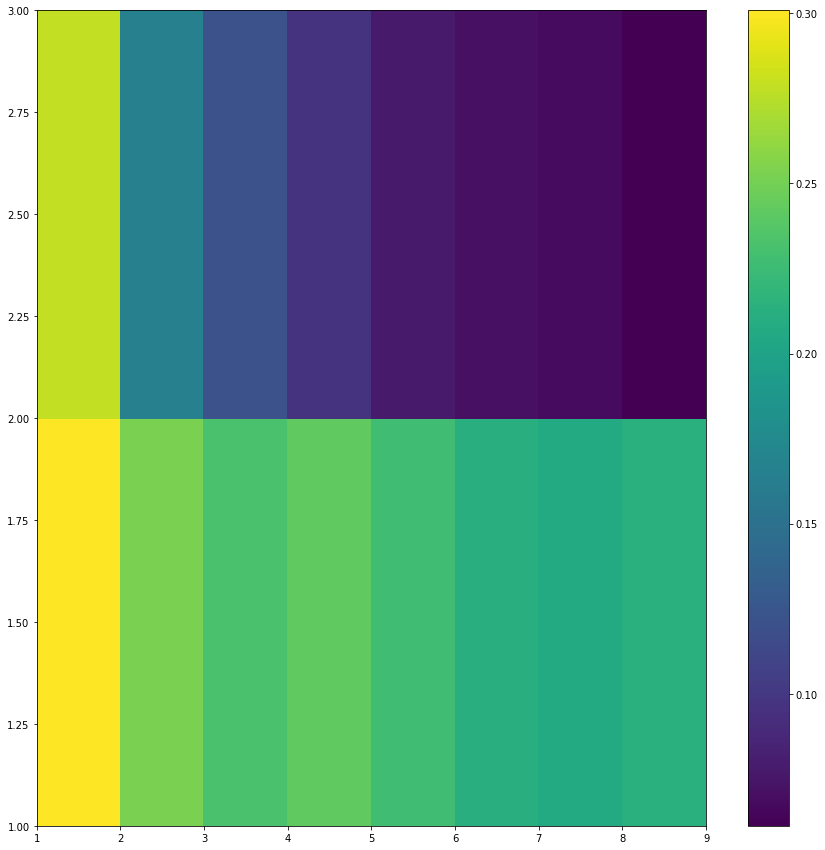

(9, 3)

In [34]:
from IPython.display import display, clear_output
from sklearn.model_selection import KFold
import time
from sklearn import metrics
import matplotlib.pyplot as plt


def cross_validate(eval_function, k):
    kf = KFold(n_splits=10)
    
    all_accuracies = []
    
    for train_folds, test_fold in kf.split(train):
        (accuracy, _, _)  = eval_function(k, 
                                 train[feature_options].iloc[train_folds], 
                                 train['morpheme'].iloc[train_folds].values.ravel(), 
                                 train[feature_options].iloc[test_fold], 
                                 train['morpheme'].iloc[test_fold].values.ravel())
        all_accuracies.append(accuracy)
    
    return 1 - (sum(all_accuracies) / len(all_accuracies))

def tune_multiple_hyperparameters(eval_function, x1_range, x2_range):
    all_errors = [] # 2d array
    min_error = 1
    min_error_indices = (-1, -1)
    
    for x1 in x1_range:
        x1_vals = []
        for x2 in x2_range:
            clear_output(wait=True)
            display(f"Trying x1={x1}, x2={x2}")
            result = cross_validate(eval_function, (x1, x2))
            
            # Keep track of the lowest error
            if result < min_error:
                min_error = result
                min_error_indices = (x2, x1)
                
            x1_vals.append(result)
        all_errors.append(x1_vals)
    
    plt.figure(figsize=(15,15))
    plt.pcolormesh(x2_range, x1_range, all_errors)
    plt.colorbar()
    plt.show()
    return min_error_indices

def eval_nn_sigmoid(hidden_layer_sizes, X_train, y_train, X_val, y_val):
    start_train = time.time()
    nn = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation='logistic', max_iter=250)
    nn.fit(X_train, y_train)
    end_train = time.time()
    
    start_predict = time.time()
    y_pred = nn.predict(X_val)
    end_predict = time.time()
    return (metrics.accuracy_score(y_val, y_pred), end_train - start_train, end_predict - start_predict)

tune_multiple_hyperparameters(eval_nn_sigmoid, range(1, 4), range(1, 10))


The above cell takes very long to run, but suggests (3,9) as the optimal hyperparameters.

In [39]:
clf = MLPClassifier(alpha=1e-5, hidden_layer_sizes=(3, 9), random_state=1, max_iter=1000)
clf.fit(train[feature_options], train["morpheme"])
print("Train: ", clf.score(train[feature_options], train["morpheme"]))
print("Test: ", clf.score(test[feature_options], test["morpheme"]))

Train:  0.9945794211596167
Test:  0.9905149051490515


In [42]:
print(predict("wug", clf, ['W', 'AH1', 'G']))
print(predict("zing", clf, ['Z', 'IH1', 'NG']))
print(predict("read", clf))

['+ed']
['+u+']
[['R', 'EH1', 'D'], ['R', 'IY1', 'D']]


Which one? 1


['+ɛ+']


### Results
With these hyperparameters, our model performs extremely well on both the training and testing data. Furthermore, it makes the same predictions in a wug test as a human. 

The R&M paper does not give an overall number for accuracy of their entire model. However, it lists that overall, 91% of wickelfeatures were correctly generated for novel (test) data. Thus, our model must be better, since 99% of test data is predicted exactly correct (all wickelfeatures correct). Granted, this is comparing apples to oranges, since our model has the additional power of only predicting morphemes and ignoring phonology.

In fact, this seems to support our hypothesis, that by distinguishing between morphology and phonology, and by building models that operate over only one of these areas, we can create much more accurate models. Consequently, this experiment provides evidence that morphology and phonology can be more effectively modeled as separate processes. 

In addition, our hypotheses about what factors would improve the model were correct. The optimal shape for the model was a deep network, indicating that our data is not linearly separable. Naturally, we benefit from modern theories and technologies, but it is fascinating to see how much we can build on R&M's model and improve it.

## Nearest Neighbors
Last, we will repeat this with a nearest neighbors model.

'Trying k=9'

1

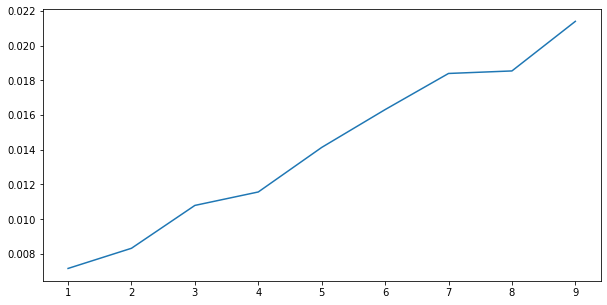

In [50]:
from sklearn.neighbors import KNeighborsClassifier

def tune_hyperparameter(eval_function, k_range):
    all_errors = []
    min_error = 1
    min_error_index = -1
    
    for k in k_range:
        clear_output(wait=True)
        display(f"Trying k={k}")
        result = cross_validate(eval_function, k)
        
        if result < min_error:
            min_error = result
            min_error_index = k
            
        all_errors.append(result)
    
    plt.figure(figsize=(10,5))
    ax1 = plt.subplot()
    ax1.set_xticks(k_range)
    ax1.plot(k_range, all_errors)
    
    return min_error_index

def eval_knn_classifier(k, X_train, y_train, X_val, y_val):
    """Returns a tuple containing (accuracy, training time, testing time)"""
    start_train = time.time()
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    end_train = time.time()
    
    start_predict = time.time()
    y_pred = knn.predict(X_val)
    end_predict = time.time()
    return (metrics.accuracy_score(y_val, y_pred), end_train - start_train, end_predict - start_predict)

tune_hyperparameter(eval_knn_classifier, range(1, 10))

We can see that the performance actually worsens with greater k. Let's build the model with `k=1`.

In [52]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(train[feature_options], train["morpheme"])

print("Train: ", clf.score(train[feature_options], train["morpheme"]))
print("Test: ", clf.score(test[feature_options], test["morpheme"]))

print(predict("wug", knn, ['W', 'AH1', 'G']))
print(predict("zing", clf, ['Z', 'IH1', 'NG']))
print(predict("read", knn))

Train:  0.9945794211596167
Test:  0.9905149051490515
[<MORPHEME.ED: '+ed'>]
['+u+']
[['R', 'EH1', 'D'], ['R', 'IY1', 'D']]


Which one? 1


[<MORPHEME.EH: '+ɛ+'>]


The nearest neighbors classifier also does extremely well on the data. One of the goals of a combined connectionist/generative model is the ability to gain information from looking at models that learn patterns. In this case, we see evidence for the theory that the primary way in which we determine which morpheme to use is by comparing a novel word to other words in terms of phonetic similarity. We can see that simply by using the closest known word, we can get very accurate results.

# Conclusion
With easy-to-use libraries and simple data processing, we have been able to replicate and improve on the Rumelhart and McClelland model for learning English past tense with a model that combines connectionist theory and morphological information. This is a promising example of how embedding generativist information can vastly improve our ability to build effective models, and to close to gap of the two schools of thought.

Furthermore, it is striking how much our ability to build, train, and test models has come from 1985. As our technology continues to advance, along with our understanding of psycholinguistics, we can build models that come closer and closer to the human brain, and help us unravel the mysteries of language.

## References
Plunkett, K., & Juola, P. (1999). A connectionist model of English past tense and plural morphology. Cognitive Science, 23(4), 463-490.

Rueckl, J. G., & Raveh, M. (1999). The influence of morphological regularities on the dynamics of a connectionist network. Brain and Language, 68(1-2), 110-117.

Rumelhart, D. E., & McClelland, J. L. (1985). On learning the past tenses of English verbs. CALIFORNIA UNIV SAN DIEGO LA JOLLA INST FOR COGNITIVE SCIENCE.